MLP training completed.

True next-7 DR (first 8 test rows):
                  h1        h2        h3        h4        h5        h6  \
2022-09-14  1.222508 -1.748588  0.349652 -0.474180 -0.051523  0.377676   
2022-09-15 -1.748588  0.349652 -0.474180 -0.051523  0.377676 -0.457229   
2022-09-16  0.349652 -0.474180 -0.051523  0.377676 -0.457229 -0.645708   
2022-09-19 -0.474180 -0.051523  0.377676 -0.457229 -0.645708  0.064152   
2022-09-20 -0.051523  0.377676 -0.457229 -0.645708  0.064152 -1.057246   
2022-09-21  0.377676 -0.457229 -0.645708  0.064152 -1.057246 -1.055825   
2022-09-22 -0.457229 -0.645708  0.064152 -1.057246 -1.055825  0.709373   
2022-09-23 -0.645708  0.064152 -1.057246 -1.055825  0.709373 -1.118794   

                  h7  
2022-09-14 -0.457229  
2022-09-15 -0.645708  
2022-09-16  0.064152  
2022-09-19 -1.057246  
2022-09-20 -1.055825  
2022-09-21  0.709373  
2022-09-22 -1.118794  
2022-09-23  0.696313  

Pred next-7 DR (first 8 test rows):
                  h1        

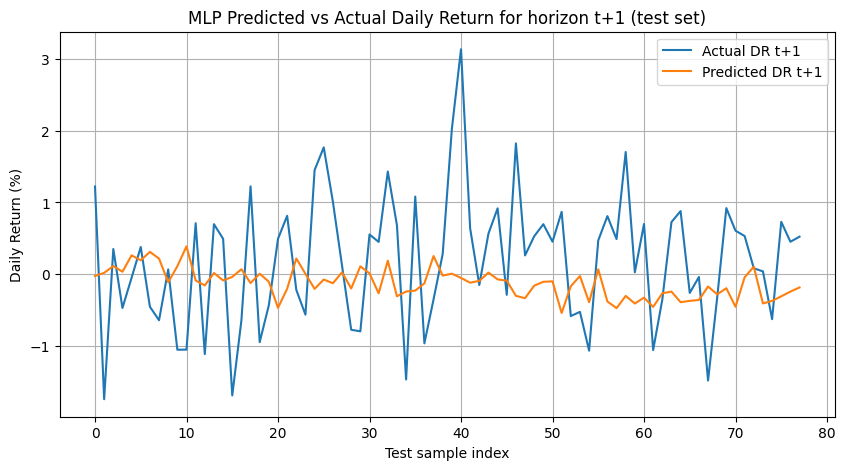

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/mlp_seq2many_bbca_demo.pkl'

In [ ]:
# Alternative implementation WITHOUT TensorFlow (for environments where TF isn't installed).
# Uses sklearn's MLPRegressor to approximate the sequence-to-many mapping:
# Input: WINDOW days × features flattened -> Output: HORIZON DR values.
# This is a practical fallback that runs in environments without TF.
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Re-create the same synthetic dataset as before (so this cell can run standalone)
start = "2020-01-01"
end = "2023-01-01"
dates = pd.bdate_range(start=start, end=end)
n = len(dates)
np.random.seed(42)
drift = 0.0003
seasonality = 2 * np.sin(np.linspace(0, 8 * np.pi, n))
noise = np.random.normal(scale=0.01, size=n).cumsum()
base = 100 + (np.arange(n) * 0.01) + seasonality + noise * 0.5
open_price = base * (1 + np.random.normal(scale=0.002, size=n))
close_price = open_price * (1 + np.random.normal(loc=drift, scale=0.01, size=n))
high = np.maximum(open_price, close_price) * (1 + np.abs(np.random.normal(scale=0.003, size=n)))
low = np.minimum(open_price, close_price) * (1 - np.abs(np.random.normal(scale=0.003, size=n)))
volume = (np.random.lognormal(mean=10, sigma=0.5, size=n)).astype(int)
df = pd.DataFrame({"date": dates, "open": open_price, "high": high, "low": low, "close": close_price, "volume": volume}).set_index("date")
df["DR"] = 100.0 * (df["close"] - df["open"]) / df["open"]

def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi
def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window, min_periods=1).mean()
    return atr
def compute_ao(close, short=5, long=34):
    sma_short = close.rolling(window=short, min_periods=1).mean()
    sma_long = close.rolling(window=long, min_periods=1).mean()
    return sma_short - sma_long

df["RSI"] = compute_rsi(df["close"], window=14)
df["ATR"] = compute_atr(df["high"], df["low"], df["close"], window=14)
df["AO"] = compute_ao(df["close"], short=5, long=34)
df["dow"] = df.index.dayofweek
df["month"] = df.index.month
dow_dummies = pd.get_dummies(df["dow"], prefix="dow")
month_dummies = pd.get_dummies(df["month"], prefix="m")
df = pd.concat([df, dow_dummies, month_dummies], axis=1)
np.random.seed(123)
news_count = np.random.poisson(lam=2.0, size=n)
sentiment = np.random.normal(scale=0.3, size=n)
sentiment_nudge = np.sign(df["DR"].shift(1).fillna(0)) * (-0.15)
sentiment = sentiment + sentiment_nudge
sentiment = np.clip(sentiment, -1, 1)
df["news_count"] = news_count
df["sentiment"] = sentiment

feature_cols = ["open", "high", "low", "close", "volume", "RSI", "ATR", "AO", "news_count", "sentiment"] \
               + list(dow_dummies.columns) + list(month_dummies.columns)
data = df[feature_cols + ["DR"]].copy().dropna()

WINDOW = 3
HORIZON = 7
X_list = []
y_list = []
dates_list = []
vals = data[feature_cols].values
dr_vals = data["DR"].values
for i in range(WINDOW, len(data) - HORIZON + 1):
    X_seq = vals[i - WINDOW:i]  # (WINDOW, feats)
    y_seq = dr_vals[i:i + HORIZON]
    X_list.append(X_seq.flatten())  # flatten for MLP
    y_list.append(y_seq)
    dates_list.append(data.index[i + HORIZON - 1])

X = np.vstack(X_list)
y = np.vstack(y_list)
total_samples = X.shape[0]
train_end = int(total_samples * 0.75)
val_end = int(total_samples * 0.90)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
dates_test = dates_list[val_end:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# MLPRegressor as fallback: outputs HORIZON targets at once
mlp = MLPRegressor(hidden_layer_sizes=(256,128), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=30)
mlp.fit(X_train_s, y_train)
print("MLP training completed.")

# predict and show results
y_pred = mlp.predict(X_test_s)
# display small DataFrame of true vs pred for the first 5 test rows (expand horizons)
true_df = pd.DataFrame(y_test[:8], columns=[f"h{j+1}" for j in range(HORIZON)], index=[d.date() for d in dates_test[:8]])
pred_df = pd.DataFrame(y_pred[:8], columns=[f"h{j+1}" for j in range(HORIZON)], index=[d.date() for d in dates_test[:8]])
print("\nTrue next-7 DR (first 8 test rows):")
print(true_df)
print("\nPred next-7 DR (first 8 test rows):")
print(pred_df)

# plot horizon-1 predicted vs true over test samples
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test[:,0], label="Actual DR t+1")
plt.plot(range(len(y_test)), y_pred[:,0], label="Predicted DR t+1")
plt.title("MLP Predicted vs Actual Daily Return for horizon t+1 (test set)")
plt.xlabel("Test sample index")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.grid(True)
plt.show()

# Save model and scaler
joblib.dump(mlp, "mlp_seq2many_bbca_demo.pkl")
joblib.dump(scaler, "feature_scaler_bbca_demo.pkl")
print("\nModel and scaler saved to /mnt/data/ for download. Files:\n - mlp_seq2many_bbca_demo.pkl\n - feature_scaler_bbca_demo.pkl")


In [1]:
import yfinance

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Is GPU available: ", tf.test.is_gpu_available(cuda_only=True))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Coba operasi sederhana
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)

print("Matrix multiplication done on GPU")

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  True
Built with CUDA:  True
Matrix multiplication done on GPU


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Default device:", tf.test.gpu_device_name())

Default device: /device:GPU:0


In [5]:
import yfinance as yf
bbca = yf.download("BBCA.JK", start="2020-01-01", end="2023-01-01", interval="1d")
bbca.head()

C:\Users\adlip\AppData\Local\Temp\ipykernel_6676\3577016423.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca = yf.download("BBCA.JK", start="2020-01-01", end="2023-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,
2020-01-02,5820.926758,5899.235190,5812.225821,5825.277226,49445000
2020-01-03,5916.637207,5916.637207,5851.380179,5873.132522,47755500
2020-01-06,5860.082031,5873.133439,5820.927808,5847.030624,27300000
2020-01-07,5864.431641,5890.534452,5855.730703,5860.081172,45022500
2020-01-08,5812.225586,5868.781673,5803.524649,5803.524649,53692500


In [6]:
bbca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2020-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BBCA.JK)   735 non-null    float64
 1   (High, BBCA.JK)    735 non-null    float64
 2   (Low, BBCA.JK)     735 non-null    float64
 3   (Open, BBCA.JK)    735 non-null    float64
 4   (Volume, BBCA.JK)  735 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 34.5 KB


In [8]:
bbca.isna().sum()

Price   Ticker 
Close   BBCA.JK    0
High    BBCA.JK    0
Low     BBCA.JK    0
Open    BBCA.JK    0
Volume  BBCA.JK    0
dtype: int64

In [11]:
# -------------------------------
# 2. Feature Engineering
# -------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=1).mean()

def compute_ao(close, short=5, long=34):
    sma_short = close.rolling(window=short, min_periods=1).mean()
    sma_long = close.rolling(window=long, min_periods=1).mean()
    return sma_short - sma_long


In [ ]:
# ===============================
# Stock Forecasting for BBCA (IDX:BBCA.JK) 
# LSTM + Heuristic Selection (like the paper)
# ===============================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Data Acquisition
# -------------------------------
bbca = yf.download("BBCA.JK", start="2023-01-01", end="2025-01-01", interval="1d")
bbca.dropna(inplace=True)

# Daily return (target variable)
print('calculate DR')
bbca["DR"] = 100 * (bbca["Close"] - bbca["Open"]) / bbca["Open"]
print('calculate DR success')
bbca['DR']

C:\Users\adlip\AppData\Local\Temp\ipykernel_6676\616935731.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca = yf.download("BBCA.JK", start="2020-01-01", end="2023-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

calculate DR
calculate DR success


Date
2020-01-02   -0.074683
2020-01-03    0.740741
2020-01-06    0.223214
2020-01-07    0.074239
2020-01-08    0.149925
                ...   
2022-12-26    0.882353
2022-12-27    0.000000
2022-12-28    0.000000
2022-12-29    0.586510
2022-12-30   -0.291545
Name: DR, Length: 735, dtype: float64

In [17]:
# Technical indicators
bbca["RSI"] = compute_rsi(bbca["Close"], 14)
bbca["ATR"] = compute_atr(bbca["High"], bbca["Low"], bbca["Close"], 14)
bbca["AO"] = compute_ao(bbca["Close"], 5, 34)

# Seasonality
bbca["dow"] = bbca.index.dayofweek
bbca["month"] = bbca.index.month
dow_dummies = pd.get_dummies(bbca["dow"], prefix="dow")
month_dummies = pd.get_dummies(bbca["month"], prefix="m")
bbca = pd.concat([bbca, dow_dummies, month_dummies], axis=1)
bbca

,"(Close, BBCA.JK)","(High, BBCA.JK)","(Low, BBCA.JK)","(Open, BBCA.JK)","(Volume, BBCA.JK)","(DR, )","(RSI, )","(ATR, )","(AO, )","(dow, )",...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,5820.926758,5899.235190,5812.225821,5825.277226,49445000,-0.074683,NaN,87.009369,0.000000,3,...,False,False,False,False,False,False,False,False,False,False
2020-01-03,5916.637207,5916.637207,5851.380179,5873.132522,47755500,0.740741,100.000000,91.359909,0.000000,4,...,False,False,False,False,False,False,False,False,False,False
2020-01-06,5860.082031,5873.133439,5820.927808,5847.030624,27300000,0.223214,62.857555,92.809739,0.000000,0,...,False,False,False,False,False,False,False,False,False,False
2020-01-07,5864.431641,5890.534452,5855.730703,5860.081172,45022500,0.074239,63.889097,78.308241,0.000000,1,...,False,False,False,False,False,False,False,False,False,False
2020-01-08,5812.225586,5868.781673,5803.524649,5803.524649,53692500,0.149925,47.916598,75.697998,0.000000,2,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,7895.059570,7941.094903,7826.006571,7826.006571,20495900,0.882353,46.000027,141.394393,-141.972668,0,...,False,False,False,False,False,False,False,False,False,True
2022-12-27,7918.078125,7964.113463,7895.060456,7918.078125,27193800,0.000000,57.142872,131.529764,-130.856678,1,...,False,False,False,False,False,False,False,False,False,True
2022-12-28,7964.112793,7964.112793,7872.042125,7964.112793,40420200,0.000000,57.142850,123.309169,-132.324885,2,...,False,False,False,False,False,False,False,False,False,True


In [25]:
bbca.iloc[0]

Close         5916.637207
High          5916.637207
Low           5851.380179
Open          5873.132522
Volume           47755500
DR               0.740741
RSI                 100.0
ATR             91.359909
AO                    0.0
dow                     4
month                   1
dow_0               False
dow_1               False
dow_2               False
dow_3               False
dow_4                True
m_1                  True
m_2                 False
m_3                 False
m_4                 False
m_5                 False
m_6                 False
m_7                 False
m_8                 False
m_9                 False
m_10                False
m_11                False
m_12                False
sentiment       -0.854616
news_count              1
Name: 2020-01-03 00:00:00, dtype: object

In [ ]:
# Dummy sentiment/news: negative if yesterday DR < 0, positive if > 0
sentiment = np.sign(bbca["DR"].shift(1).fillna(0))
sentiment = sentiment + np.random.normal(scale=0.2, size=len(sentiment))  # add some noise
bbca["sentiment"] = np.clip(sentiment, -1, 1)
bbca["news_count"] = np.random.poisson(lam=2.0, size=len(bbca))

# Drop NaNs
bbca = bbca.dropna()

In [ ]:
# -------------------------------
# 3. Dataset Preparation
# -------------------------------
feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "RSI", "ATR", "AO", "sentiment", "news_count"] \
               + list(dow_dummies.columns) + list(month_dummies.columns)

WINDOW = 3
X, y = [], []
dates = []

vals = bbca[feature_cols].values
dr_vals = bbca["DR"].values

for i in range(WINDOW, len(bbca)):
    X.append(vals[i-WINDOW:i])      # 3-day features
    y.append(dr_vals[i])            # next-day DR
    dates.append(bbca.index[i])

X = np.array(X)
y = np.array(y)

# Train/test split (time-based)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = dates[split:]

# Feature scaling
scaler = StandardScaler()
nsamples, nsteps, nfeatures = X_train.shape
X_train_reshaped = X_train.reshape(-1, nfeatures)
scaler.fit(X_train_reshaped)

def scale_X(X_in):
    return scaler.transform(X_in.reshape(-1, nfeatures)).reshape(X_in.shape)

X_train_s = scale_X(X_train)
X_test_s = scale_X(X_test)


In [ ]:
# -------------------------------
# 4. Forecasting Model (LSTM)
# -------------------------------
tf.random.set_seed(42)

model = Sequential([
    LSTM(128, input_shape=(WINDOW, nfeatures), activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="linear")  # predict next-day DR
])

model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
history = model.fit(X_train_s, y_train, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)

In [ ]:
# -------------------------------
# 5. Predictions + Heuristic Scoring
# -------------------------------
y_pred = model.predict(X_test_s).flatten()

# Heuristic score (as in the paper)
scores = []
for true, pred in zip(y_test, y_pred):
    if np.sign(true) == np.sign(pred):  # correct direction
        scores.append(1 / (1 + abs(true - pred)))
    else:  # wrong direction
        scores.append(-abs(true - pred))

results = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_pred,
    "score": scores
}).set_index("date")

print(results.head())

In [ ]:
# -------------------------------
# 6. Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(results.index, results["true_DR"], label="Actual DR")
plt.plot(results.index, results["pred_DR"], label="Predicted DR")
plt.legend()
plt.title("BBCA Daily Return Prediction (LSTM, 3-day window)")
plt.grid(True)
plt.show()

# Distribution of heuristic scores
plt.figure(figsize=(6,4))
plt.hist(results["score"], bins=50, color="skyblue")
plt.title("Heuristic Score Distribution (BBCA)")
plt.show()


C:\Users\adlip\AppData\Local\Temp\ipykernel_6676\4135843780.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca = yf.download("BBCA.JK", start="2020-01-01", end="2023-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Epoch 1/30
17/17 [==============================] - 4s 25ms/step - loss: 3.0979 - mae: 1.2175 - val_loss: 2.1893 - val_mae: 1.1306
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.9089 - mae: 1.1765 - val_loss: 2.2542 - val_mae: 1.1526
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 2.8296 - mae: 1.1715 - val_loss: 2.2897 - val_mae: 1.1659
Epoch 4/30
17/17 [==============================] - 0s 5ms/step - loss: 2.7760 - mae: 1.1619 - val_loss: 2.3273 - val_mae: 1.1774
Epoch 5/30
17/17 [==============================] - 0s 5ms/step - loss: 2.7065 - mae: 1.1466 - val_loss: 2.3920 - val_mae: 1.2026
Epoch 6/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6883 - mae: 1.1521 - val_loss: 2.4111 - val_mae: 1.2089
Epoch 7/30
17/17 [==============================] - 0s 5ms/step - loss: 2.5898 - mae: 1.1343 - val_loss: 2.3444 - val_mae: 1.1928
Epoch 8/30
17/17 [==============================] - 0s 6ms/step - loss: 2.5390 - mae: 1.1

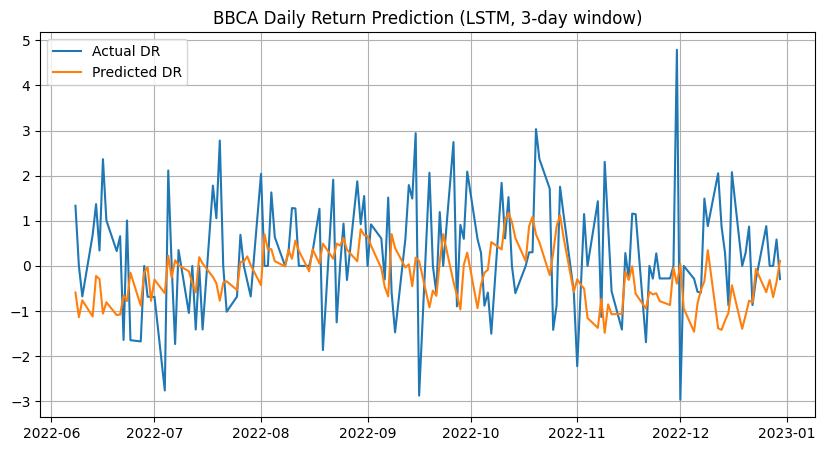

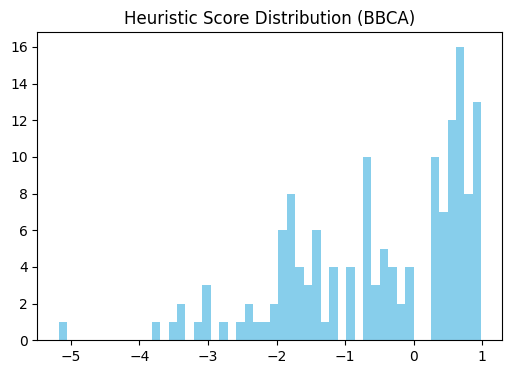

In [19]:
# ===============================
# Stock Forecasting for BBCA (IDX:BBCA.JK)
# LSTM + Heuristic Selection
# ===============================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Data Acquisition
# -------------------------------
bbca = yf.download("BBCA.JK", start="2020-01-01", end="2023-01-01", interval="1d")
bbca.dropna(inplace=True)

# kalau ada multiindex di kolom, flatten dulu
if isinstance(bbca.columns, pd.MultiIndex):
    bbca.columns = bbca.columns.get_level_values(0)

# -------------------------------
# 2. Daily Return (Target Variable)
# -------------------------------
bbca["DR"] = 100 * (bbca["Close"] - bbca["Open"]) / bbca["Open"]

# -------------------------------
# 3. Technical Indicators
# -------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=1).mean()

def compute_ao(close, short=5, long=34):
    sma_short = close.rolling(window=short, min_periods=1).mean()
    sma_long = close.rolling(window=long, min_periods=1).mean()
    return sma_short - sma_long

bbca["RSI"] = compute_rsi(bbca["Close"], 14)
bbca["ATR"] = compute_atr(bbca["High"], bbca["Low"], bbca["Close"], 14)
bbca["AO"]  = compute_ao(bbca["Close"], 5, 34)

# -------------------------------
# 4. Seasonality Features
# -------------------------------
bbca["dow"] = bbca.index.dayofweek
bbca["month"] = bbca.index.month
dow_dummies = pd.get_dummies(bbca["dow"], prefix="dow")
month_dummies = pd.get_dummies(bbca["month"], prefix="m")
bbca = bbca.join(dow_dummies).join(month_dummies)

# -------------------------------
# 5. Dummy Sentiment / News
# -------------------------------
sentiment = np.sign(bbca["DR"].shift(1).fillna(0))
sentiment = sentiment + np.random.normal(scale=0.2, size=len(sentiment))  # tambahkan noise
bbca["sentiment"] = np.clip(sentiment, -1, 1)
bbca["news_count"] = np.random.poisson(lam=2.0, size=len(bbca))

# -------------------------------
# 6. Final Dataset (drop NaNs)
# -------------------------------
bbca = bbca.dropna()

feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "RSI", "ATR", "AO", "sentiment", "news_count"] \
               + list(dow_dummies.columns) + list(month_dummies.columns)

# -------------------------------
# 7. Sequence Preparation
# -------------------------------
WINDOW = 3
X, y, dates = [], [], []

vals = bbca[feature_cols].values
dr_vals = bbca["DR"].values

for i in range(WINDOW, len(bbca)):
    X.append(vals[i-WINDOW:i])  # 3 hari sebelumnya
    y.append(dr_vals[i])        # return besok
    dates.append(bbca.index[i])

X = np.array(X)
y = np.array(y)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = dates[split:]

# Normalisasi
scaler = StandardScaler()
nsamples, nsteps, nfeatures = X_train.shape
X_train_s = scaler.fit_transform(X_train.reshape(-1, nfeatures)).reshape(X_train.shape)
X_test_s = scaler.transform(X_test.reshape(-1, nfeatures)).reshape(X_test.shape)

# -------------------------------
# 8. LSTM Model
# -------------------------------
tf.random.set_seed(42)

model = Sequential([
    LSTM(128, input_shape=(WINDOW, nfeatures), activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="linear")  # output DR besok
])

model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
history = model.fit(X_train_s, y_train, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)

# -------------------------------
# 9. Prediction + Heuristic Score
# -------------------------------
y_pred = model.predict(X_test_s).flatten()

scores = []
for true, pred in zip(y_test, y_pred):
    if np.sign(true) == np.sign(pred):  # trend benar
        scores.append(1 / (1 + abs(true - pred)))
    else:  # trend salah
        scores.append(-abs(true - pred))

results = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_pred,
    "score": scores
}).set_index("date")

print(results.head())

# -------------------------------
# 10. Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(results.index, results["true_DR"], label="Actual DR")
plt.plot(results.index, results["pred_DR"], label="Predicted DR")
plt.legend()
plt.title("BBCA Daily Return Prediction (LSTM, 3-day window)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(results["score"], bins=50, color="skyblue")
plt.title("Heuristic Score Distribution (BBCA)")
plt.show()


C:\Users\adlip\AppData\Local\Temp\ipykernel_6676\3623318139.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca = yf.download("BBCA.JK", start="2023-01-01", end="2025-09-19", interval="1d")
[*********************100%***********************]  1 of 1 completed


Train: (427, 3, 27), Val: (140, 3, 27), Test: (70, 3, 27)
Epoch 1/30
14/14 [==============================] - 1s 30ms/step - loss: 1.2461 - mae: 0.8441 - val_loss: 2.4964 - val_mae: 1.1854
Epoch 2/30
14/14 [==============================] - 0s 9ms/step - loss: 1.1741 - mae: 0.8187 - val_loss: 2.5107 - val_mae: 1.1933
Epoch 3/30
14/14 [==============================] - 0s 11ms/step - loss: 1.1411 - mae: 0.8059 - val_loss: 2.5142 - val_mae: 1.1888
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 1.1285 - mae: 0.8019 - val_loss: 2.5194 - val_mae: 1.1910
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 1.1021 - mae: 0.7914 - val_loss: 2.5461 - val_mae: 1.1982
Epoch 6/30
14/14 [==============================] - 0s 6ms/step - loss: 1.0851 - mae: 0.7881 - val_loss: 2.5610 - val_mae: 1.1999
Epoch 7/30
14/14 [==============================] - 0s 6ms/step - loss: 1.0505 - mae: 0.7736 - val_loss: 2.5533 - val_mae: 1.1937
Epoch 8/30
14/14 [============

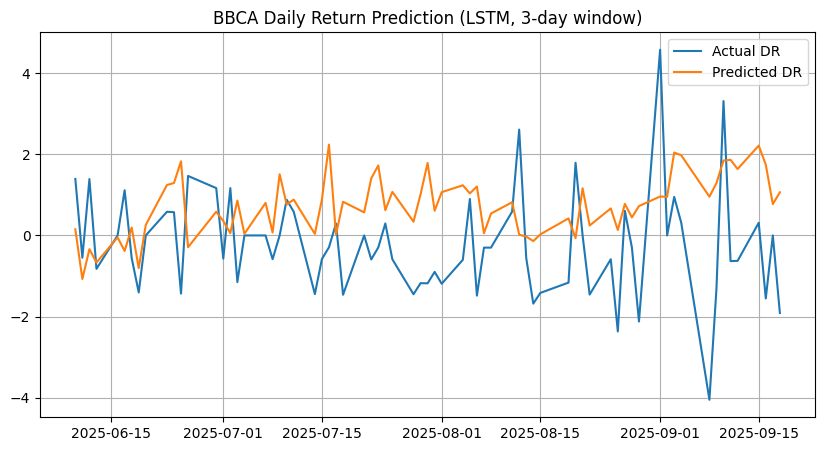

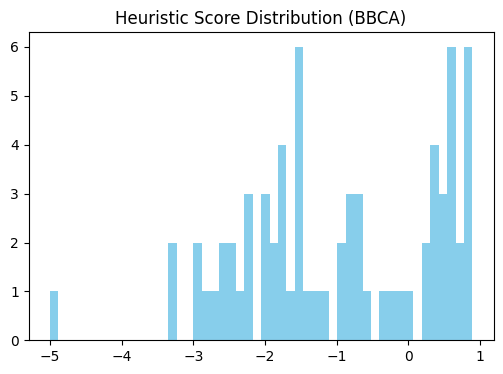

In [30]:
# ===============================
# BBCA Stock Forecasting Pipeline
# Data: 2023-01-01 sampai 2025-08-31
# LSTM + Heuristic Score
# ===============================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Data Acquisition
# -------------------------------
bbca = yf.download("BBCA.JK", start="2023-01-01", end="2025-09-19", interval="1d")
bbca.dropna(inplace=True)

# flatten multiindex columns if exists
if isinstance(bbca.columns, pd.MultiIndex):
    bbca.columns = bbca.columns.get_level_values(0)

# -------------------------------
# 2. Daily Return (Target Variable)
# -------------------------------
bbca["DR"] = 100 * (bbca["Close"] - bbca["Open"]) / bbca["Open"]

# -------------------------------
# 3. Technical Indicators
# -------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=1).mean()

def compute_ao(close, short=5, long=34):
    sma_short = close.rolling(window=short, min_periods=1).mean()
    sma_long = close.rolling(window=long, min_periods=1).mean()
    return sma_short - sma_long

bbca["RSI"] = compute_rsi(bbca["Close"], 14)
bbca["ATR"] = compute_atr(bbca["High"], bbca["Low"], bbca["Close"], 14)
bbca["AO"]  = compute_ao(bbca["Close"], 5, 34)

# -------------------------------
# 4. Seasonality Features
# -------------------------------
bbca["dow"] = bbca.index.dayofweek
bbca["month"] = bbca.index.month
dow_dummies = pd.get_dummies(bbca["dow"], prefix="dow")
month_dummies = pd.get_dummies(bbca["month"], prefix="m")
bbca = bbca.join(dow_dummies).join(month_dummies)

# -------------------------------
# 5. Dummy Sentiment / News
# -------------------------------
sentiment = np.sign(bbca["DR"].shift(1).fillna(0))
sentiment = sentiment + np.random.normal(scale=0.2, size=len(sentiment))  # add noise
bbca["sentiment"] = np.clip(sentiment, -1, 1)
bbca["news_count"] = np.random.poisson(lam=2.0, size=len(bbca))

# -------------------------------
# 6. Final Dataset
# -------------------------------
bbca = bbca.dropna()

feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "RSI", "ATR", "AO", "sentiment", "news_count"] \
               + list(dow_dummies.columns) + list(month_dummies.columns)

# -------------------------------
# 7. Sequence Preparation
# -------------------------------
WINDOW = 3
X, y, dates = [], [], []

vals = bbca[feature_cols].values
dr_vals = bbca["DR"].values

for i in range(WINDOW, len(bbca)):
    X.append(vals[i-WINDOW:i])  # 3 hari sebelumnya
    y.append(dr_vals[i])        # return besok
    dates.append(bbca.index[i])

X = np.array(X)
y = np.array(y)

# -------------------------------
# 8. Dataset Splitting
# -------------------------------
# validation = 140 hari terakhir sebelum test
# test = 70 hari terakhir (Jul–Aug 2025)
# train = sisanya dari awal

test_size = 70
val_size = 140
total = len(X)

X_train = X[:-(val_size+test_size)]
y_train = y[:-(val_size+test_size)]
dates_train = dates[:-(val_size+test_size)]

X_val = X[-(val_size+test_size):-test_size]
y_val = y[-(val_size+test_size):-test_size]
dates_val = dates[-(val_size+test_size):-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]
dates_test = dates[-test_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# -------------------------------
# 9. Scaling
# -------------------------------
scaler = StandardScaler()
nsamples, nsteps, nfeatures = X_train.shape
X_train_s = scaler.fit_transform(X_train.reshape(-1, nfeatures)).reshape(X_train.shape)
X_val_s   = scaler.transform(X_val.reshape(-1, nfeatures)).reshape(X_val.shape)
X_test_s  = scaler.transform(X_test.reshape(-1, nfeatures)).reshape(X_test.shape)

# -------------------------------
# 10. LSTM Model
# -------------------------------
tf.random.set_seed(42)

model = Sequential([
    LSTM(128, input_shape=(WINDOW, nfeatures), activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="linear")
])

model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
history = model.fit(X_train_s, y_train,
                    validation_data=(X_val_s, y_val),
                    epochs=30, batch_size=32, verbose=1)

# -------------------------------
# 11. Predictions + Heuristic Score
# -------------------------------
y_pred = model.predict(X_test_s).flatten()

scores = []
for true, pred in zip(y_test, y_pred):
    if np.sign(true) == np.sign(pred):  # correct direction
        scores.append(1 / (1 + abs(true - pred)))
    else:  # wrong direction
        scores.append(-abs(true - pred))

results = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_pred,
    "score": scores
}).set_index("date")

print(results.head())

# -------------------------------
# 12. Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(results.index, results["true_DR"], label="Actual DR")
plt.plot(results.index, results["pred_DR"], label="Predicted DR")
plt.legend()
plt.title("BBCA Daily Return Prediction (LSTM, 3-day window)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(results["score"], bins=50, color="skyblue")
plt.title("Heuristic Score Distribution (BBCA)")
plt.show()


In [34]:
X_test[1]

array([[9100.0, 9125.0, 8950.0, 8975.0, 93357200, 49.180327868400965,
        192.85714285714286, 228.82352941176396, -0.22505709505660698, 3,
        False, False, True, False, False, False, False, False, False,
        False, True, False, False, False, False, False, False],
       [9000.0, 9050.0, 8900.0, 8925.0, 95529000, 36.53846153806805,
        182.14285714285714, 103.23529411764684, -0.810720587340144, 0,
        False, False, False, True, False, False, False, False, False,
        False, True, False, False, False, False, False, False],
       [8975.0, 9100.0, 8950.0, 9100.0, 80406400, 44.06779660975122,
        183.92857142857142, 18.97058823529369, -1.0, 1, False, True,
        False, False, False, False, False, False, False, False, True,
        False, False, False, False, False, False]], dtype=object)

3/3 [==============================] - 0s 0s/step


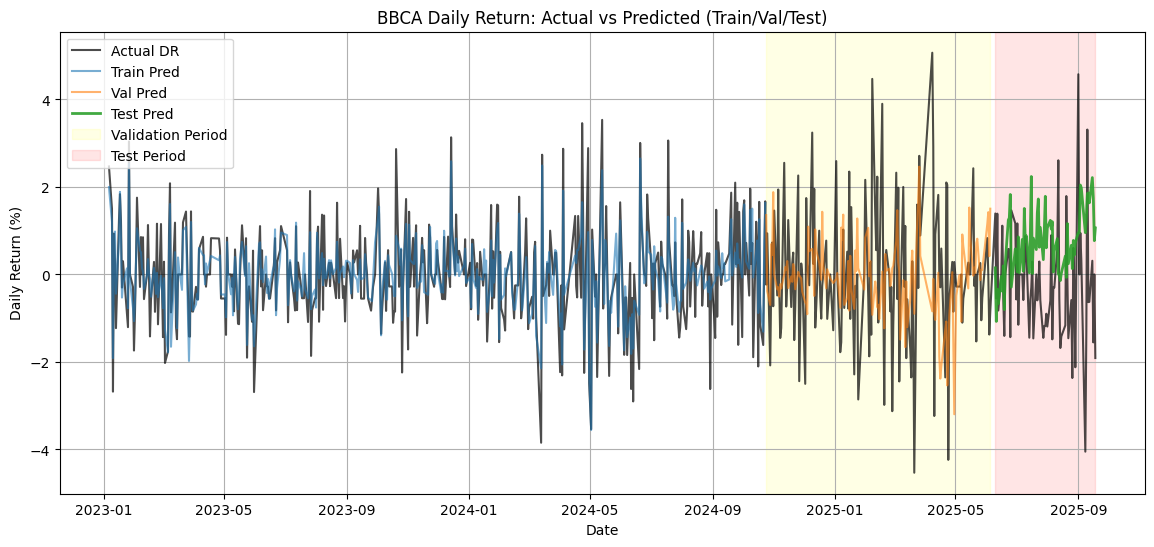

In [35]:
# -------------------------------
# 13. Predict on all splits
# -------------------------------
y_train_pred = model.predict(X_train_s).flatten()
y_val_pred   = model.predict(X_val_s).flatten()
y_test_pred  = model.predict(X_test_s).flatten()

# gabungkan ke dataframe
df_train = pd.DataFrame({
    "date": dates_train,
    "true_DR": y_train,
    "pred_DR": y_train_pred,
    "set": "train"
})

df_val = pd.DataFrame({
    "date": dates_val,
    "true_DR": y_val,
    "pred_DR": y_val_pred,
    "set": "val"
})

df_test = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_test_pred,
    "set": "test"
})

results_all = pd.concat([df_train, df_val, df_test]).set_index("date")

# -------------------------------
# 14. Visualization (all data)
# -------------------------------
plt.figure(figsize=(14,6))
plt.plot(results_all.index, results_all["true_DR"], label="Actual DR", color="black", alpha=0.7)

# plot per subset dengan warna berbeda
plt.plot(df_train["date"], df_train["pred_DR"], label="Train Pred", alpha=0.6)
plt.plot(df_val["date"], df_val["pred_DR"], label="Val Pred", alpha=0.6)
plt.plot(df_test["date"], df_test["pred_DR"], label="Test Pred", alpha=0.9, linewidth=2)

plt.axvspan(df_val["date"].iloc[0], df_val["date"].iloc[-1], color="yellow", alpha=0.1, label="Validation Period")
plt.axvspan(df_test["date"].iloc[0], df_test["date"].iloc[-1], color="red", alpha=0.1, label="Test Period")

plt.title("BBCA Daily Return: Actual vs Predicted (Train/Val/Test)")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.grid(True)
plt.show()
